In [1]:
import os, sys
from collections import defaultdict
from tqdm import tqdm
import time

In [2]:
import gymnasium as gym
from text_flappy_bird_gym import *
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4, seed=0)
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

env.reset()

((13, 2), {'score': 0, 'player': [6, 7], 'distance': 13.152946437965905})

In [4]:
class SARSAAgent():
    def __init__(self, num_actions,epsilon,eps_decay,lr,discount,seed):
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.lr = lr
        self.discount = discount
        self.rand_generator = np.random.RandomState(seed)
        self.Q = defaultdict(lambda: 0)
        
        self.pre_state = 0
        self.pre_action = 0
    
    def argmax(self, q_values):
        top = float('-inf')
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = [i]
            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)

    def agent_start(self, state):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_step(self, reward, state, episode, num_episodes):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
            
        predict = self.Q[self.pre_state, self.pre_action]
        target = reward + self.discount * self.Q[state, action]
        
        self.Q[self.pre_state, self.pre_action] += self.lr*(target - predict)
            
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_end(self, reward):
        self.Q[self.pre_state, self.pre_action] += self.lr * (reward - self.Q[self.pre_state, self.pre_action])
        

    def train(self, env, num_episodes):
        # self.num_episodes = num_episodes
        scores = []
        awards = []
        for episode in tqdm(range(num_episodes)):
            episode_rewards = 0
            state, _ = env.reset()
            if episode == 0:
                action = self.agent_start(state)
            else:
                while True:
                    next_state, reward, done, _, info = env.step(action)
                    next_action = self.agent_step(reward, next_state, episode, num_episodes)
                    episode_rewards += reward
                    if (info['score'] >1e2) or done:
                        self.agent_end(reward)
                        break
                    state = next_state
                    action = next_action
                scores.append(info['score'])
                awards.append(episode_rewards)
            self.epsilon = max(self.epsilon * self.eps_decay, 0.005)
        return np.array(awards), np.array(scores)

    def test(self, env, n_episodes):
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            while not done:
                action = np.argmax([self.Q[state,0], self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                state = next_state
                if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                    break
            scores.append(info['score'])
        return np.array(scores)

    def run(self, env):
        state,_ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = np.argmax([self.Q[state,0], self.Q[state,1]])
            next_state, reward,done,_, info = env.step(action)
            episode_reward += reward
            state = next_state
            if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                break
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.2) # FPS
        return info['score']

In [5]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()

((13, -5), {'score': 0, 'player': [6, 7], 'distance': 13.92838827718412})

100%|██████████| 10000/10000 [00:21<00:00, 463.53it/s]


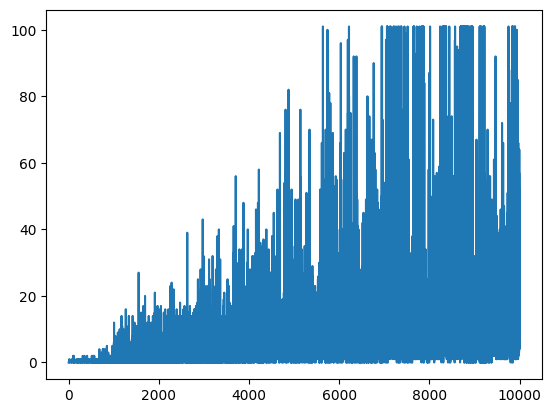

In [6]:
game = SARSAAgent(num_actions=2,epsilon=0.5,eps_decay=0.9995,lr=0.4,discount=0.9,seed=None)
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

n_episodes = 10000
_, train_score = game.train(env, n_episodes)
plt.plot(train_score)
plt.show()

In [7]:
env = gym.make('TextFlappyBird-v0', height=10, width=20, pipe_gap=4)
game.run(env)

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=2)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=1)
Text Flappy Bird!
Score: 0
----------------------
[                |   ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                |   ]
[                |   ]
[                |   ]
[                |   ]
[                |   ]
^^^^^^^^

101

100%|██████████| 100/100 [00:00<00:00, 321.38it/s]

Average scores over 100 test episodes: 34.09
Median scores over 100 test episodes: 28.0


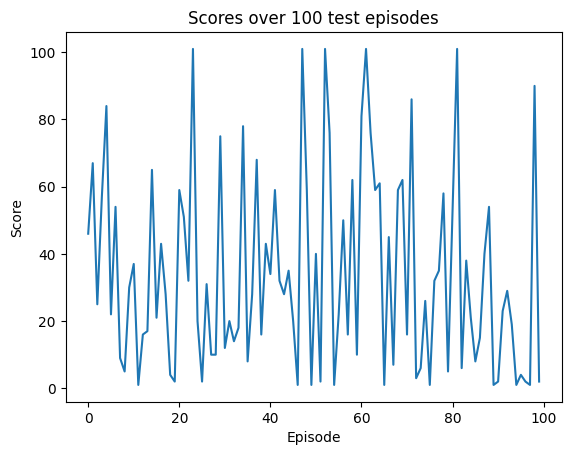

In [8]:
# test the trained agent for 100 episodes
n_episodes=100
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
test_scores = game.test(env,n_episodes=n_episodes)
print(f"Average scores over {n_episodes} test episodes:", np.mean(test_scores))
print(f"Median scores over {n_episodes} test episodes:", np.median(test_scores))

# plot the scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} test episodes")
plt.show()